# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Díaz Campos José Juan

**Professor**: Pablo Camarillo Ramirez

## Producer (30 points)
```python
import time
import json
import random
from kafka import KafkaProducer
from kafka.errors import NoBrokersAvailable
from data_generator import EcommDataGenerator

KAFKA_SERVER = 'localhost:9092'
TOPIC_NAME = 'ecomm_sales_stream'

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

print("Iniciando productor de e-commerce...")

try:
    # --- 2. Creación de Instancias ---
    generator = EcommDataGenerator(num_clientes=500, num_productos=100)
    
    producer = KafkaProducer(
        bootstrap_servers=[KAFKA_SERVER],
        value_serializer=json_serializer
    )

    print(f"Conectado a Kafka en {KAFKA_SERVER}. Enviando datos al topic '{TOPIC_NAME}'...")
    
    # --- 3. Bucle de Producción Continua ---
    while True:
        sale_record = generator.generate_sale_record()
        
        print(f"Produciendo Venta ID: {sale_record['venta_id']}")
        producer.send(TOPIC_NAME, value=sale_record)
        
        time.sleep(random.uniform(0.5, 2.0))

except NoBrokersAvailable:
    print(f"Error: No se pudo conectar a Kafka en {KAFKA_SERVER}.")
    print("Asegúrate de que tu clúster de Kafka esté corriendo.")
except KeyboardInterrupt:
    print("\nDeteniendo productor...")
finally:
    if 'producer' in locals() and producer:
        print("Cerrando conexión con Kafka.")
        producer.flush()
        producer.close()


## Consumer

### Dataset and Stream creation (10 points)


In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, to_date, trim, year, month
from PabloQuintero.spark_utils import SparkUtils 

In [2]:
spark = SparkSession.builder \
    .appName("ProyectoFinalStream_JoseJuanDiaz") \
    .master("local[*]") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-94c35dd7-e114-4dd5-9fb9-2fce5f6c4d6a;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

In [3]:
schema_columns = [
    ("venta_id", "StringType"),
    ("fecha", "StringType"),
    ("cliente_id", "StringType"),
    ("nombre_cliente", "StringType"),
    ("ciudad_cliente", "StringType"),
    ("email_cliente", "StringType"),
    ("producto_id", "StringType"),
    ("nombre_producto", "StringType"),
    ("categoria_producto", "StringType"),
    ("precio_unitario", "DoubleType"),
    ("cantidad", "IntegerType"),
    ("total_venta", "DoubleType")
]
sales_schema = SparkUtils.generate_schema(schema_columns)


In [4]:
kafka_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9093") \
    .option("subscribe", "ecomm_sales_stream") \
    .load()

In [5]:
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), sales_schema).alias("data")
).select("data.*")

### Transformations and Actions (15 points)

In [6]:
df_cleaned = parsed_df \
    .withColumn("fecha_dt", to_date(col("fecha"), "yyyy-MM-dd")) \
    .withColumn("nombre_cliente", trim(col("nombre_cliente"))) \
    .withColumn("ciudad_cliente", trim(col("ciudad_cliente"))) \
    .withColumn("nombre_producto", trim(col("nombre_producto"))) \
    .withColumn("categoria_producto", trim(col("categoria_producto"))) \
    .dropna(subset=["venta_id", "fecha_dt", "cliente_id", "producto_id", "total_venta"])

df_final = df_cleaned \
    .withColumn("year", year(col("fecha_dt"))) \
    .withColumn("month", month(col("fecha_dt")))

df_final.printSchema()

root
 |-- venta_id: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- cliente_id: string (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- ciudad_cliente: string (nullable = true)
 |-- email_cliente: string (nullable = true)
 |-- producto_id: string (nullable = true)
 |-- nombre_producto: string (nullable = true)
 |-- categoria_producto: string (nullable = true)
 |-- precio_unitario: double (nullable = true)
 |-- cantidad: integer (nullable = true)
 |-- total_venta: double (nullable = true)
 |-- fecha_dt: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



### Persistence Data (15 points)

In [7]:
OUTPUT_PATH = "/opt/spark/work-dir/data/project_output"
CHECKPOINT_PATH = "/opt/spark/work-dir/project_checkpoint"

query = df_final.writeStream \
    .format("parquet") \
    .outputMode("append") \
    .partitionBy("year", "month") \
    .option("path", OUTPUT_PATH) \
    .option("checkpointLocation", CHECKPOINT_PATH) \
    .trigger(processingTime='30 seconds') \
    .start()

### Power BI Dashboard (10 points)

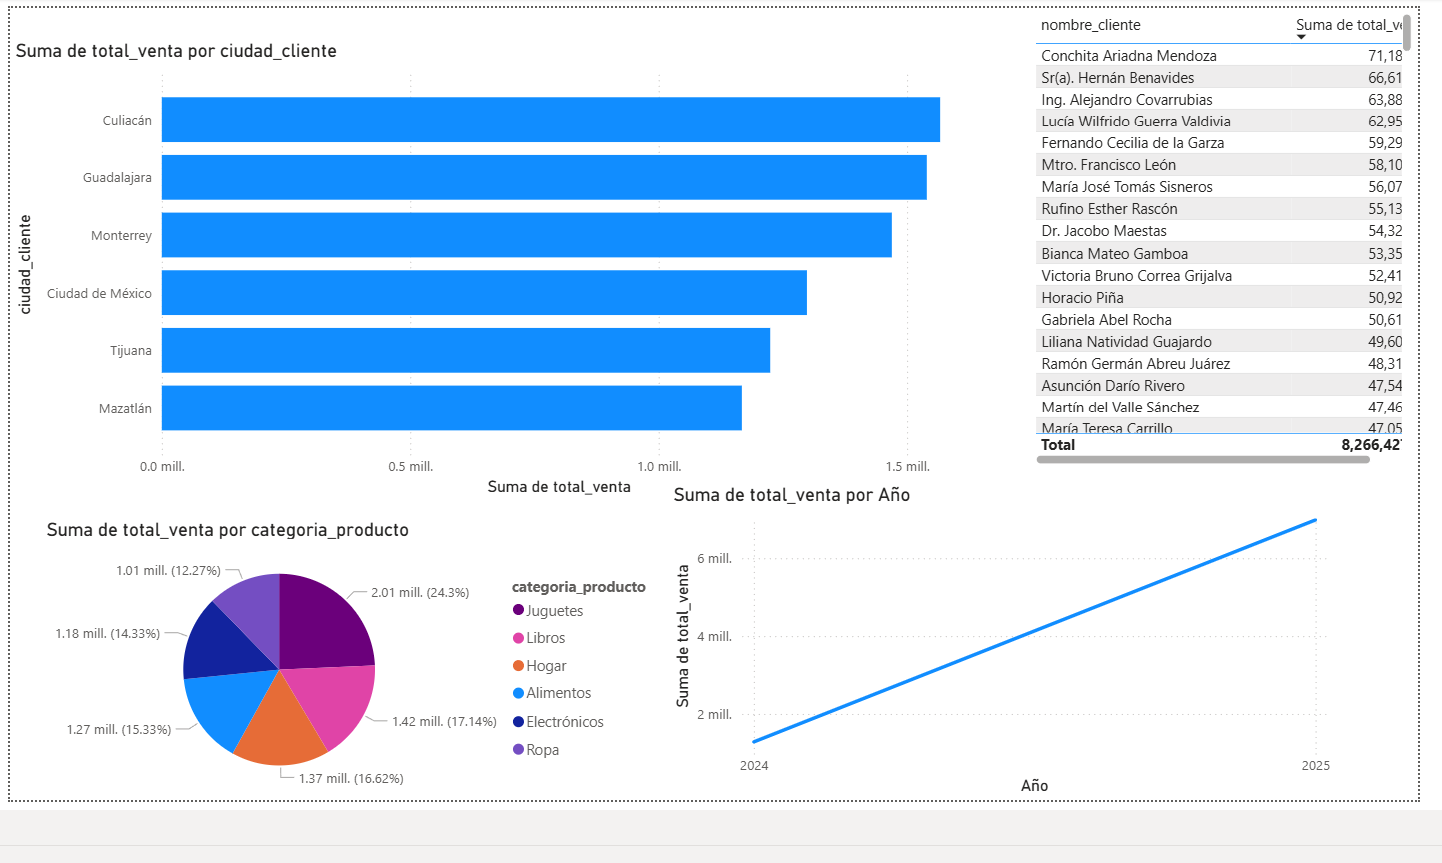